<a href="https://colab.research.google.com/github/shin-sooin/Spaceship-Titanic/blob/main/spaceship_titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

# Import Libraries

In [2]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,StandardScaler,OneHotEncoder,MinMaxScaler

from sklearn.model_selection import train_test_split,cross_val_score,RandomizedSearchCV

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from lightgbm import LGBMClassifier

# Load dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(6)
memory usage: 823.6+ KB


<Axes: >

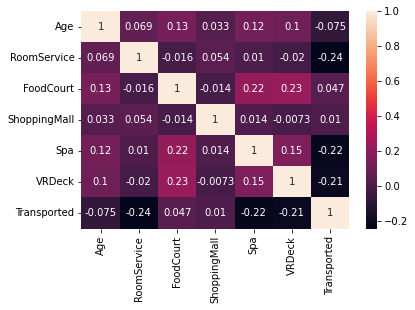

In [3]:
df=pd.read_csv('/content/train (1).csv')

df.drop(columns=['Name'], inplace=True)
df.info()
sns.heatmap(df.corr(), annot=True)

In [4]:
for c in df.columns:
  value=df[c].unique()
  if len(value)<10:
    print(c, ': ', df[c].unique())
  else:
    print(c)

PassengerId
HomePlanet :  ['Europa' 'Earth' 'Mars' nan]
CryoSleep :  [False True nan]
Cabin
Destination :  ['TRAPPIST-1e' 'PSO J318.5-22' '55 Cancri e' nan]
Age
VIP :  [False True nan]
RoomService
FoodCourt
ShoppingMall
Spa
VRDeck
Transported :  [False  True]


# Preprocess dataset

- column 'Cabin' & 'PassengerId'

In [5]:
# preprocess 'Cabin' column
def cabin_process(data):
  data['Cabin'].fillna("np.nan/np.nan/np.nan", inplace=True)
  data['Cabin_Deck']=data['Cabin'].apply(lambda x: x.split('/')[0])
  data['Cabin_Number']=data['Cabin'].apply(lambda x:x.split('/')[1])
  data['Cabin_Side']=data['Cabin'].apply(lambda x: x.split('/')[2])
  cols=['Cabin_Deck','Cabin_Number','Cabin_Side']
  data[cols]=data[cols].replace('np.nan', np.nan)

def passenger_id_process(data):
  data['Group']=data['PassengerId'].apply(lambda x: x.split('_')[0])
  data['NumInGroup']=data['PassengerId'].apply(lambda x:x.split('_')[1])

In [6]:
cabin_process(df)
passenger_id_process(df)
df.drop(columns=['PassengerId','Cabin'], inplace=True)
df.sample(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_Deck,Cabin_Number,Cabin_Side,Group,NumInGroup
996,Earth,False,TRAPPIST-1e,19.0,False,0.0,0.0,27.0,53.0,677.0,False,F,201,S,1058,01
6695,Earth,False,TRAPPIST-1e,21.0,False,0.0,13.0,0.0,720.0,170.0,False,F,1464,P,7062,01
323,Earth,False,TRAPPIST-1e,15.0,False,358.0,212.0,33.0,0.0,112.0,False,F,67,S,0360,01
6467,Mars,False,TRAPPIST-1e,24.0,False,3481.0,0.0,1236.0,2.0,256.0,False,F,1306,S,6825,02
3561,Earth,False,55 Cancri e,34.0,False,71.0,0.0,242.0,393.0,0.0,False,G,627,S,3830,01


- 'Cabin_Number' & 'Group' columns

In [7]:
df[['Cabin_Number', 'Group']] = df[['Cabin_Number', 'Group']].apply(pd.to_numeric)
df.sample(5)

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_Deck,Cabin_Number,Cabin_Side,Group,NumInGroup
5811,Mars,True,TRAPPIST-1e,NaN,False,0.0,0.0,0.0,0.0,0.0,True,F,1176.0,S,6148,02
5953,NaN,False,TRAPPIST-1e,34.0,False,6.0,878.0,0.0,10.0,2203.0,False,D,190.0,S,6313,02
8178,Europa,True,TRAPPIST-1e,14.0,False,0.0,0.0,0.0,0.0,0.0,True,A,91.0,P,8741,01
115,Mars,True,TRAPPIST-1e,24.0,False,0.0,0.0,0.0,0.0,NaN,True,F,25.0,P,120,01
3606,Mars,True,TRAPPIST-1e,30.0,False,0.0,0.0,0.0,0.0,0.0,True,F,799.0,P,3872,01


# FillNa

In [8]:
def fill_nan(data, columns):
  for col in columns:
    if data[col].dtype in ['object', 'bool']:
      data[col].fillna(data[col].mode()[0], inplace=True)
    elif data[col].dtype in ['int64','float64']:
      data[col].fillna(data[col].mean(),inplace=True)
    

In [9]:
fill_nan(df, df.columns)
df.sample(5)
df.isnull().sum()

HomePlanet      0
CryoSleep       0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Transported     0
Cabin_Deck      0
Cabin_Number    0
Cabin_Side      0
Group           0
NumInGroup      0
dtype: int64

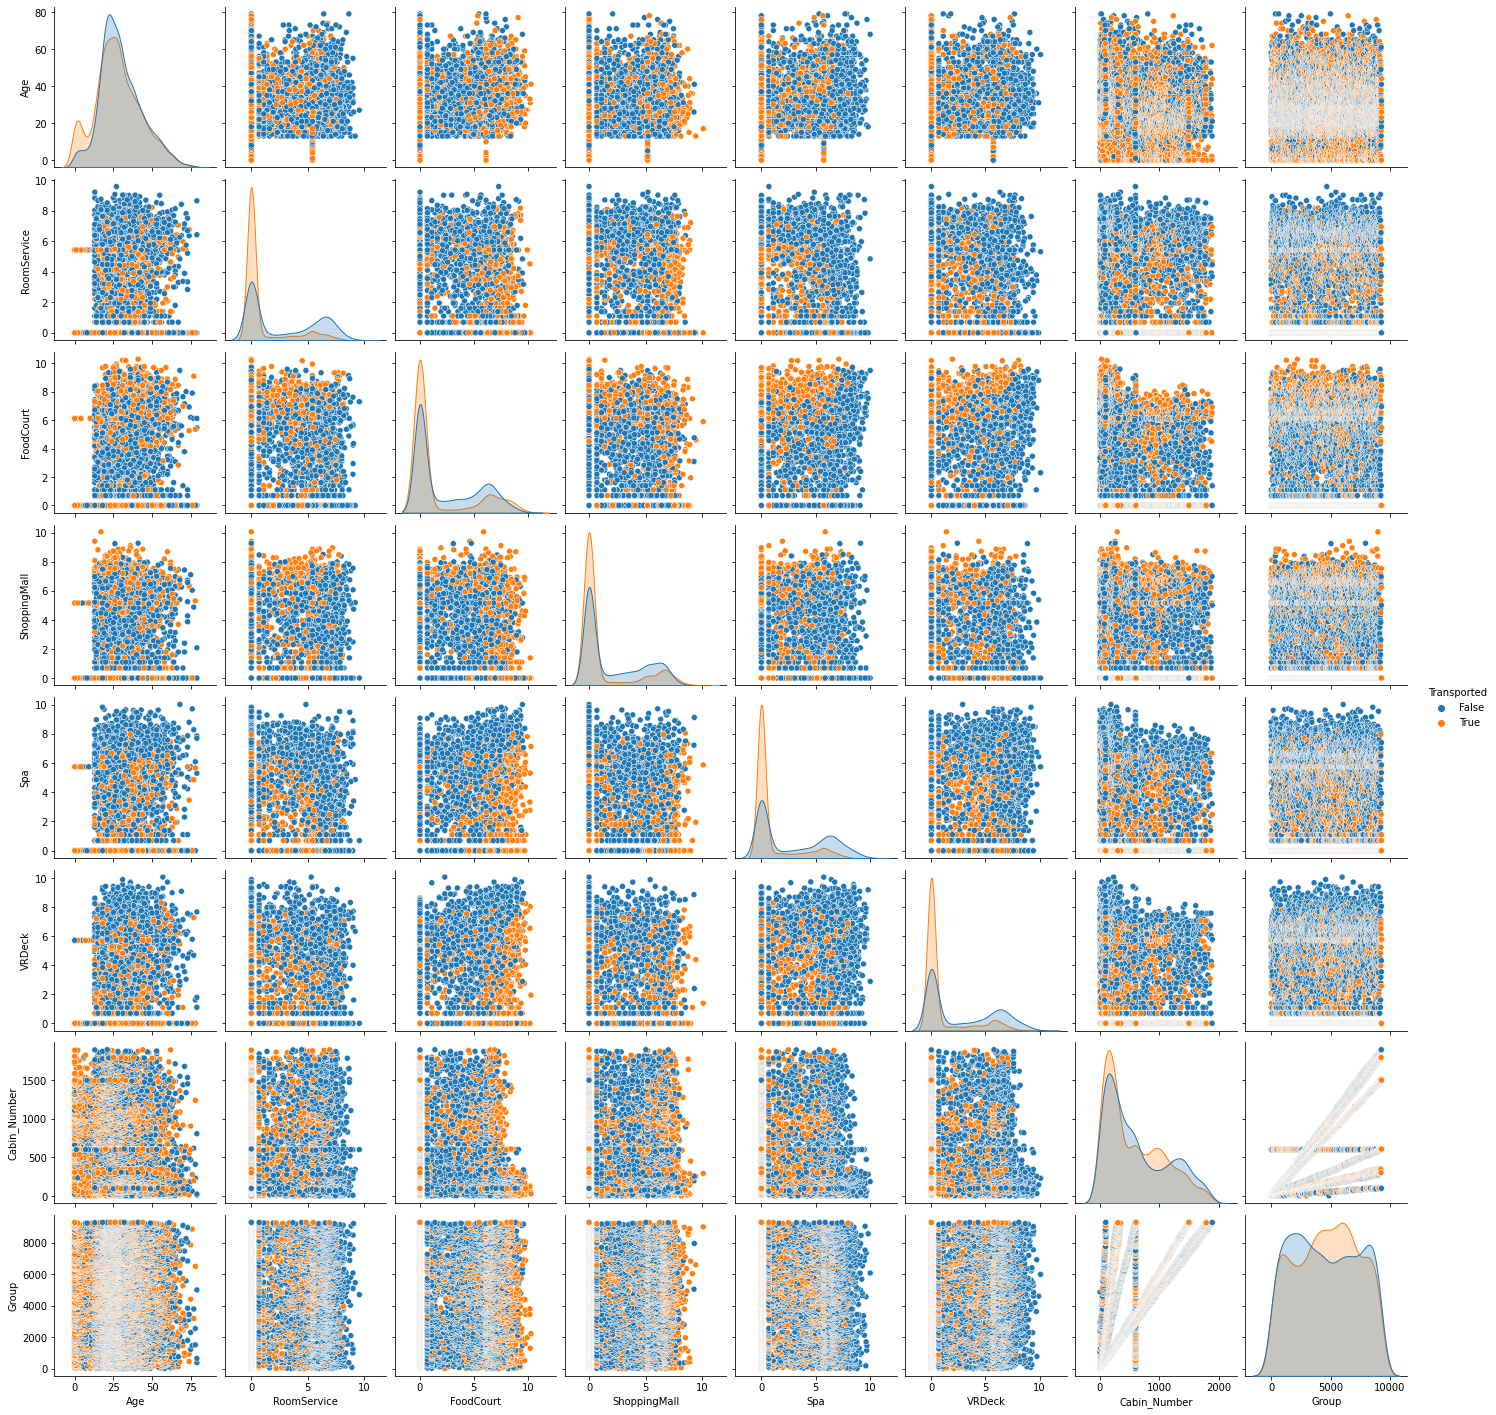

In [10]:
# log transform
def log_transform(data, columns):
  for col in columns:
    data[col]=np.log1p(data[col])

amenities=['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck']
log_transform(df, amenities)

num_cols=[col for col in df.columns if df[col].dtype in ['int64','float64']]
df_num=pd.DataFrame(data=df, columns=num_cols)
df_num['Transported']=df['Transported']
sns.pairplot(df_num, hue='Transported')

In [11]:
def univariate_plot(data, columns, plot):
  plt.figure(figsize=(20,20))
  for i in enumerate(data[columns]):
    plt.subplot(len(columns)//2, len(columns)//2,i[0]+1)
    plot(x=data[i[1]])

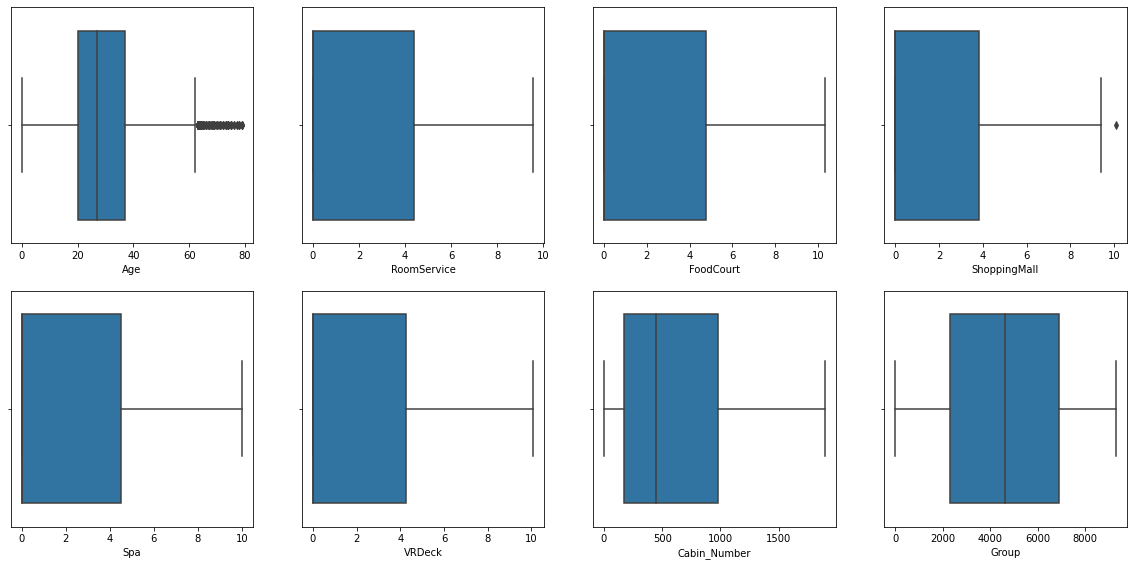

In [12]:
univariate_plot(df, num_cols, sns.boxplot)

# Remove Outliers

In [13]:
def remove_outlier(data, col):
  q1=data[col].quantile(0.25)
  q3=data[col].quantile(0.75)
  iqr=q3-q1
  data_out=data.loc[(data[col]>q1-1.5*iqr)&(data[col]<q3+1.5*iqr)]
  return data_out

In [14]:
df=remove_outlier(df, 'Age')

# Deal with Categorical data

In [15]:
categorical=[col for col in df.columns if df[col].dtype in ['object','bool']]
categorical

['HomePlanet',
 'CryoSleep',
 'Destination',
 'VIP',
 'Transported',
 'Cabin_Deck',
 'Cabin_Side',
 'NumInGroup']

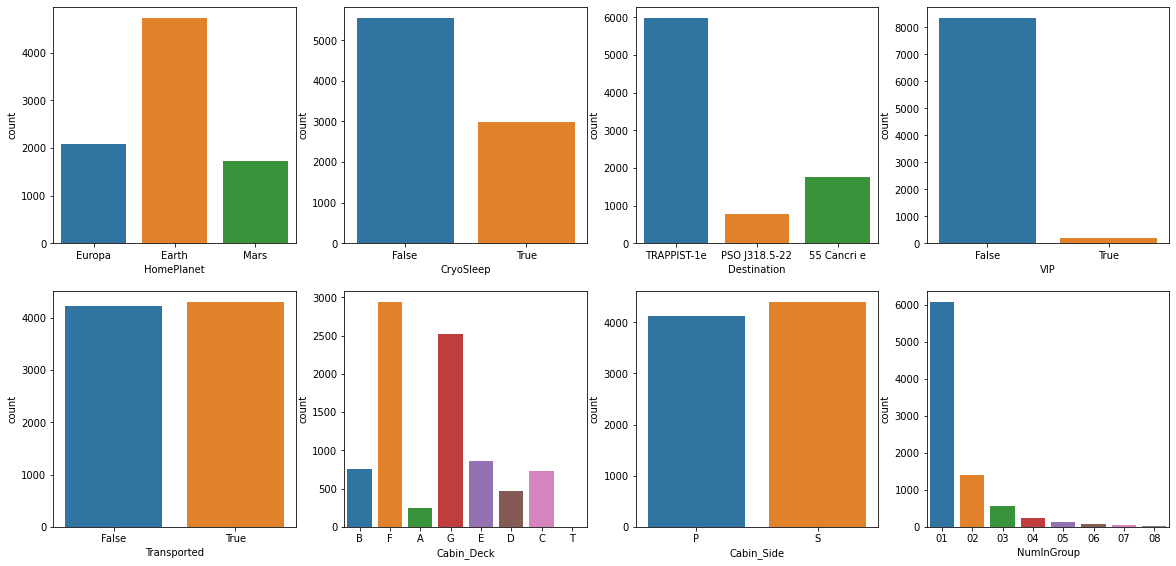

In [16]:
univariate_plot(df, categorical, sns.countplot)

In [17]:
destinations=df['Destination'].unique()
for i in range(0,destinations.size):
  label='Destination_'+str(i+1)
  df['Destination'].replace({destinations[i]:label},inplace=True)

# Encoding

In [18]:
# check unique values of variables in each columns
for col in df.columns:
  # print(col)
  if df[col].unique().size<5:
    print(col,' : ',df[col].unique())
  else:
    print(col,' : ',df[col].unique().size)

HomePlanet  :  ['Europa' 'Earth' 'Mars']
CryoSleep  :  [False  True]
Destination  :  ['Destination_1' 'Destination_2' 'Destination_3']
Age  :  64
VIP  :  [False  True]
RoomService  :  1259
FoodCourt  :  1486
ShoppingMall  :  1104
Spa  :  1304
VRDeck  :  1289
Transported  :  [False  True]
Cabin_Deck  :  8
Cabin_Number  :  1816
Cabin_Side  :  ['P' 'S']
Group  :  6120
NumInGroup  :  8


In [19]:
label_encoder=LabelEncoder()
label_cols=['Cabin_Deck','NumInGroup']
one_hot_cols=['HomePlanet','CryoSleep','Destination','VIP','Cabin_Side']

In [20]:
# Label Encoder
for col in label_cols:
  df[col]=label_encoder.fit_transform(df[col])
df=pd.get_dummies(data=df, columns=one_hot_cols, drop_first=True)
df.sample(5)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,Cabin_Deck,Cabin_Number,Group,NumInGroup,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_True,Destination_Destination_2,Destination_Destination_3,VIP_True,Cabin_Side_S
1846,22.0,0.000000,0.0,0.000000,2.397895,6.635947,False,6,310.0,1975,0,0,0,0,0,0,0,1
2085,19.0,0.000000,0.0,0.000000,0.000000,0.000000,False,4,134.0,2234,2,0,1,0,0,0,0,0
7829,17.0,0.000000,0.0,0.000000,0.000000,0.000000,True,1,326.0,8360,0,1,0,1,0,0,0,1
7723,21.0,6.214608,0.0,5.267858,0.693147,0.693147,False,5,1579.0,8239,0,0,0,0,0,1,0,1
4907,23.0,5.575949,0.0,7.345365,3.806662,0.000000,True,5,1004.0,5230,0,0,1,0,0,0,0,1


# Split data (independent & dependent)

In [21]:
# split target variable
x=df.drop(columns='Transported')
y=df['Transported']

x_train, x_valid, y_train, y_valid = train_test_split(x,y,test_size=0.3, shuffle=True)
print(x_train.shape)
print(x_valid.shape)
print(y_train.shape)
print(y_valid.shape)

(5971, 17)
(2560, 17)
(5971,)
(2560,)


# Models

In [22]:
logr= LogisticRegression()
dtc = DecisionTreeClassifier()
knn = KNeighborsClassifier()
gnb = GaussianNB()
sgd = SGDClassifier()
svm = SVC()
rfc =  RandomForestClassifier()
ada =  AdaBoostClassifier()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

models = [logr,dtc,knn,gnb,sgd,svm,rfc,ada,lgbm]
scaler=MinMaxScaler()

In [23]:
def predictions_traindata(model, x_train, y_train, x_test, y_test):
  # scale x
  x_train=scaler.fit_transform(x_train)
  x_test=scaler.fit_transform(x_test)
  # fit model
  model.fit(x_train, y_train)
  y_pred_train=model.predict(x_train)
  y_pred_test=model.predict(x_test)
  print('ACCURACY_TRAIN: ', accuracy_score(y_train, y_pred_train))
  print('ACCURACY_VALID: ', accuracy_score(y_test, y_pred_test))
  print('CLASSIFICATION_REPORT:\n', classification_report(y_test, y_pred_test))
  print('CONFUSION_MATRIX: ',confusion_matrix(y_test, y_pred_test))
  scores=cross_val_score(model, x, y, cv=5, scoring='accuracy')
  print('CROSS_VAL_SCORE: ',scores)
  print('MEAN_SCORE: ', scores.mean())

In [24]:
# toIntCol=['NumInGroup','HomePlanet_Europa','HomePlanet_Mars','CryoSleep_True','Destination_Destination_2','Destination_Destination_3','Cabin_Side_S']
# for col in toIntCol:
#   df[col]=df[col].astype('int32')
# df['VIP_True']=df['VIP_True'].astype('bool')
for model in models:
  print(model,'\n')
  predictions_traindata(model, x_train, y_train, x_valid, y_valid)
  print('-------'*40)
# for col in df.columns:
#   print(df[col].dtype)


LogisticRegression() 

ACCURACY_TRAIN:  0.7749120750293084
ACCURACY_VALID:  0.770703125
CLASSIFICATION_REPORT:
               precision    recall  f1-score   support

       False       0.78      0.75      0.77      1296
        True       0.76      0.79      0.77      1264

    accuracy                           0.77      2560
   macro avg       0.77      0.77      0.77      2560
weighted avg       0.77      0.77      0.77      2560

CONFUSION_MATRIX:  [[977 319]
 [268 996]]
CROSS_VAL_SCORE:  [0.74516696 0.74618992 0.75615475 0.77198124 0.74853458]
MEAN_SCORE:  0.7536054903916087
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
DecisionTreeClassifier() 

ACCURACY_TRAIN:  1.0
ACCURACY_VALID:  0.741796875
CLASSIFICATION_REPORT:
               precision    rec

<BarContainer object of 17 artists>

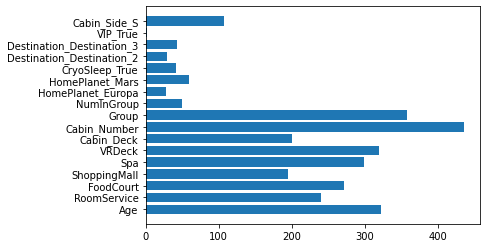

In [25]:
model_1=lgbm
plt.barh(x_train.columns, lgbm.feature_importances_)

In [26]:
# Choose top 3 models with the highest accuracy
chosenModels=[lgbm,ada,rfc]
for model in chosenModels:
  print(model)
  print(model.get_params(),'\n')

LGBMClassifier()
{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 

AdaBoostClassifier()
{'algorithm': 'SAMME.R', 'base_estimator': 'deprecated', 'estimator': None, 'learning_rate': 1.0, 'n_estimators': 50, 'random_state': None} 

RandomForestClassifier()
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 've

In [27]:
grid_lgbm={
    'n_estimators':[10,20,30,50,100,150,200],
    'learning_rate':[0.01,0.02,0.03,0.05,0.1],
    'random_state':[0,20,40,50,70,100],
    'num_leaves':[10,15,20]
}
grid_ada={
    'n_estimators':[10,20,30,50,100,150,200],
    'learning_rate':[0.1,0.3,0.5,1.0,2.0],
    'random_state':[0,20,40,50,70,100]
}
grid_rfc={
    'n_estimators':[10,20,30,50,100,150,200],
    'min_samples_split':[3,5,7,10,20],
    'min_samples_leaf':[3,5,7,10,15,20],
    'max_depth':[10,12,15,20,50]
}
params=[grid_lgbm, grid_ada,grid_rfc]

In [28]:
# GridSearch function
def bestParams(model, param):
  random_search=RandomizedSearchCV(model,param, cv=5)
  random_search.fit(x_train, y_train.values.ravel())
  print('\n', chosenModels[i])
  print('best score: ',random_search.best_score_)
  print('best params: ',random_search.best_params_)
  return random_search.best_params_

# random_search_lgbm=RandomizedSearchCV(lgbm,grid_lgbm,cv=5, n_jobs=-1)
# random_search_lgbm.fit(x_train, y_train.values.ravel())

In [29]:
def cal_accuracy(best_model, x_train, y_train, x_valid, y_valid):
  best_model.fit(x_train, y_train)
  y_train_predictions=best_model.predict(x_train)
  y_valid_predictions=best_model.predict(x_valid)
  train_score=accuracy_score(y_train, y_train_predictions)
  valid_score=accuracy_score(y_valid,y_valid_predictions)
  print('train_accuracy: ', train_score)
  print('valid_accuracy: ', valid_score,'\n')

In [30]:
# accuracy of LGBM
best_param=[]
for i in range(0,3):
  best_param.append(bestParams(chosenModels[i],params[i]))

best_lgbm=LGBMClassifier(**best_param[0])
best_ada=AdaBoostClassifier(**best_param[1])
best_rfc=RandomForestClassifier(**best_param[2])

# print accuracy of models on train & valid set
print('-'*15,'\nMODEL ACCURACY','-'*15,'\n')
cal_accuracy(best_lgbm, x_train, y_train, x_valid, y_valid)
cal_accuracy(best_ada, x_train, y_train, x_valid, y_valid)
cal_accuracy(best_rfc, x_train, y_train, x_valid, y_valid)


 LGBMClassifier()
best score:  0.8032136974972491
best params:  {'random_state': 20, 'num_leaves': 10, 'n_estimators': 200, 'learning_rate': 0.03}

 AdaBoostClassifier()
best score:  0.792325785132076
best params:  {'random_state': 40, 'n_estimators': 100, 'learning_rate': 1.0}

 RandomForestClassifier()
best score:  0.7978534233230308
best params:  {'n_estimators': 150, 'min_samples_split': 20, 'min_samples_leaf': 10, 'max_depth': 20}
--------------- 
MODEL ACCURACY --------------- 

train_accuracy:  0.8248199631552504
valid_accuracy:  0.8078125 

train_accuracy:  0.8062301122090102
valid_accuracy:  0.795703125 

train_accuracy:  0.8449170993133478
valid_accuracy:  0.806640625 



# LGBM Parameter Tuning
## -- on  progress




In [31]:
lgbm.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': 'warn',
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [32]:
random_grid_xgb={
    'n_estimators': [10,20,40,50,100,150,200,500],
    'max_depth':[3,5,7,9,11,15],
    'learning_rate':[0.05,0.1,0.3,0.5,1.0]
}
random_search_xgb=RandomizedSearchCV(xgb,random_grid_xgb,cv=5,n_jobs=-1)


In [33]:
random_search_xgb.fit(x_train, y_train.values.ravel())

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
                                           predictor=None, random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'learning_rate': [0.05, 0.1, 0.3, 0.5,
                                                          1.0],
                                        'max_depth': [3, 5, 7, 9, 11, 15],
                                        'n_estimators': [10, 20, 40, 50, 100,
                                                         150, 200, 500]})

In [34]:
print('best score: ', random_search_xgb.best_score_)
best_param=random_search_xgb.best_params_
print('best params: ', best_param)

best score:  0.8027102037383571
best params:  {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.05}


In [35]:
best_xgb=XGBClassifier(**best_param)
cal_accuracy(best_xgb, x_train, y_train, x_valid, y_valid)

train_accuracy:  0.8162786802880589
valid_accuracy:  0.803515625 



# Test Data

In [36]:
df_test=pd.read_csv('/content/test.csv')
df_submission=pd.DataFrame(df_test['PassengerId'])
df_submission

,PassengerId
0,0013_01
1,0018_01
2,0019_01
3,0021_01
4,0023_01
...,...
4272,9266_02
4273,9269_01
4274,9271_01
4275,9273_01


In [37]:
df_test.shape

(4277, 13)

In [38]:
df_test.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64

In [39]:
df_test.drop(columns='Name',inplace=True)
cabin_process(df_test)
passenger_id_process(df_test)
df_test.isnull().sum()

PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin             0
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Cabin_Deck      100
Cabin_Number    100
Cabin_Side      100
Group             0
NumInGroup        0
dtype: int64

In [40]:
df_test.drop(columns=['PassengerId','Cabin'],inplace=True)
df_test[['Cabin_Number','Group']]=df_test[['Cabin_Number','Group']].apply(pd.to_numeric)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   HomePlanet    4190 non-null   object 
 1   CryoSleep     4184 non-null   object 
 2   Destination   4185 non-null   object 
 3   Age           4186 non-null   float64
 4   VIP           4184 non-null   object 
 5   RoomService   4195 non-null   float64
 6   FoodCourt     4171 non-null   float64
 7   ShoppingMall  4179 non-null   float64
 8   Spa           4176 non-null   float64
 9   VRDeck        4197 non-null   float64
 10  Cabin_Deck    4177 non-null   object 
 11  Cabin_Number  4177 non-null   float64
 12  Cabin_Side    4177 non-null   object 
 13  Group         4277 non-null   int64  
 14  NumInGroup    4277 non-null   object 
dtypes: float64(7), int64(1), object(7)
memory usage: 501.3+ KB


In [41]:
df_test.isnull().sum()

HomePlanet       87
CryoSleep        93
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Cabin_Deck      100
Cabin_Number    100
Cabin_Side      100
Group             0
NumInGroup        0
dtype: int64

In [42]:
test_cols=df_test.columns
test_cols

Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin_Deck',
       'Cabin_Number', 'Cabin_Side', 'Group', 'NumInGroup'],
      dtype='object')

In [43]:
fill_nan(df_test, test_cols)
log_transform(df_test, amenities)
df_test['Destination'].replace({'TRAPPIST-1e':'Destination_1','55 Cancri e':'Destination_2','PSO J318.5-22':'Destination_3'},inplace=True)
for col in label_cols:
  df_test[col]=label_encoder.fit_transform(df_test[col])
df_test=pd.get_dummies(data=df_test, columns=one_hot_cols, drop_first=True)
df_test.sample(5)

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Cabin_Deck,Cabin_Number,Group,NumInGroup,HomePlanet_Europa,HomePlanet_Mars,CryoSleep_True,Destination_Destination_2,Destination_Destination_3,VIP_True,Cabin_Side_S
3508,27.0,0.000000,0.000000,2.197225,7.113142,2.639057,5,1456.0,7612,0,0,0,0,0,0,0,1
2183,24.0,6.426488,2.302585,4.430817,0.000000,0.000000,6,772.0,4727,0,0,0,0,0,0,0,1
1801,18.0,0.693147,6.475433,0.000000,0.000000,0.000000,5,724.0,3843,0,0,0,0,0,0,0,1
2941,35.0,0.000000,6.555357,4.158883,2.564949,4.624973,5,1342.0,6484,0,0,0,0,0,0,0,0
276,31.0,0.000000,6.061457,5.183442,7.051856,6.933423,4,40.0,616,0,0,0,0,0,0,0,1


# Apply Ensenble 

In [59]:
result=[]
result.append(best_lgbm.predict(df_test).astype(np.bool))
result.append(best_xgb.predict(df_test).astype(np.bool))
result.append(best_rfc.predict(df_test).astype(np.bool))

IndexError: ignored

In [ ]:
final_result=[]
for i in range(0,len(result[0])):
  t=0
  f=0
  for j in range(0,3):
    if result[j][i]:
      t=t+1
    else:
      f=f+1
  if t>f:
    final_result.append(True)
  else:
    final_result.append(False)
final_result    

In [62]:
df_submission['Transported']=final_result

In [63]:
df_submission

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [64]:
df_submission.to_csv('SpaceShip_Titanic_Submission.csv',index=False)

# Submission

In [45]:
# prediction=best_lgbm.predict(df_test)
prediction=best_lgbm.predict(df_test)
prediction=prediction.astype(np.bool)
prediction

array([ True, False,  True, ...,  True,  True,  True])

In [46]:
df_submission['Transported']=prediction

In [47]:
df_submission.sample(5)

,PassengerId,Transported
2300,5022_01,False
1676,3601_05,True
1893,4054_03,False
1573,3373_01,True
3837,8399_01,False


In [48]:
df_submission['Transported'].value_counts()

True     2298
False    1979
Name: Transported, dtype: int64

In [49]:
df_submission.to_csv('SpaceShip_Titanic_Submission.csv',index=False)